In [29]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
import seaborn as sb
import xgboost as xgb
import joblib
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, precision_recall_curve, classification_report
from sklearn.impute import SimpleImputer
from sklearn.calibration import calibration_curve

In [30]:
#from google.colab import drive

# it will ask for your google drive credentiaals
#drive.mount('/content/drive/', force_remount=True)

#global path variable
#path="/content/drive/MyDrive/Colab Notebooks/ML/ProjetoML_WINE/"

path="./data/"

In [31]:
# Dataset File Path
filePath_red = path + "winequality-red.csv"
filePath_white = path + "winequality-white.csv"
filePath_weather = path + "weather-porto-2024.csv"

df1 = pd.read_csv(filePath_red)
df1['type'] = '0'
df2 = pd.read_csv(filePath_white)
df2['type'] = '1'

weather_df = pd.read_csv(filePath_weather, delimiter=';')

wine_df = pd.concat([df1, df2], ignore_index=True)

print("Nr. rows - wines: ", len(wine_df))

Nr. rows - wines:  6497


In [32]:
wine_df.head()

# Fix column names for both datasets
wine_df.columns = wine_df.columns.str.replace(' ', '_')
weather_df.columns = weather_df.columns.str.replace(' ', '_')

In [33]:
# Filter Summer season (August, September and October) from the weather dataset
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], format='%d/%m/%Y %H:%M')
weather_filtered = weather_df[(weather_df['timestamp'].dt.month >= 8) & (weather_df['timestamp'].dt.month <= 10)]

# Generate random dates within the weather data range for the wine dataset
min_date = weather_filtered['timestamp'].min()
max_date = weather_filtered['timestamp'].max()
wine_df['timestamp'] = np.random.choice(pd.date_range(min_date, max_date), size=len(wine_df))

# Merge datasets on timestamp
df = pd.merge_asof(wine_df.sort_values('timestamp'),
                             weather_df.sort_values('timestamp'),
                             on='timestamp',
                             direction='nearest')

In [34]:
print("Nr. rows - df: ", len(df))

Nr. rows - df:  6497


In [35]:
# Check final dataset
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,...,name,barometricpressure,precipitation,relativehumidity,solarradiation,temperature,uv_index,uvindexmax,winddirection,windspeed
0,7.3,0.25,0.36,13.1,0.050,35.0,200.0,0.99860,3.04,0.46,...,urn:ngsi-ld:WeatherObserved:porto:weather:weat...,NaN,0.0,0.91,0.0,7.777778,NaN,0.0,101.0,0.44704
1,8.3,0.60,0.25,2.2,0.118,9.0,38.0,0.99616,3.15,0.53,...,urn:ngsi-ld:WeatherObserved:porto:weather:weat...,NaN,0.0,0.91,0.0,7.777778,NaN,0.0,101.0,0.44704
2,8.3,0.16,0.48,1.7,0.057,31.0,98.0,0.99430,3.15,0.41,...,urn:ngsi-ld:WeatherObserved:porto:weather:weat...,NaN,0.0,0.91,0.0,7.777778,NaN,0.0,101.0,0.44704
3,7.5,0.34,0.28,4.0,0.028,46.0,100.0,0.98958,3.20,0.50,...,urn:ngsi-ld:WeatherObserved:porto:weather:weat...,NaN,0.0,0.91,0.0,7.777778,NaN,0.0,101.0,0.44704
4,7.0,0.31,0.29,1.4,0.037,33.0,128.0,0.98960,3.12,0.36,...,urn:ngsi-ld:WeatherObserved:porto:weather:weat...,NaN,0.0,0.91,0.0,7.777778,NaN,0.0,101.0,0.44704


In [36]:
# Display basic information about the DataFrame
print(df.info())

# Display descriptive statistics for numerical features
print(df.describe())

print(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   fixed_acidity         6497 non-null   float64       
 1   volatile_acidity      6497 non-null   float64       
 2   citric_acid           6497 non-null   float64       
 3   residual_sugar        6497 non-null   float64       
 4   chlorides             6497 non-null   float64       
 5   free_sulfur_dioxide   6497 non-null   float64       
 6   total_sulfur_dioxide  6497 non-null   float64       
 7   density               6497 non-null   float64       
 8   pH                    6497 non-null   float64       
 9   sulphates             6497 non-null   float64       
 10  alcohol               6497 non-null   float64       
 11  quality               6497 non-null   int64         
 12  type                  6497 non-null   object        
 13  timestamp         

In [37]:
# Get the categorical variables from df
categorical_features = [feature for feature in df.columns if df[feature].dtype == object]
print(categorical_features)

['type', 'date_observed', 'time_observed', 'entity_id', 'entity_type', 'name']


['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'timestamp', 'latitude', 'longitude', 'barometricpressure', 'precipitation', 'relativehumidity', 'solarradiation', 'temperature', 'uv_index', 'uvindexmax', 'winddirection', 'windspeed']


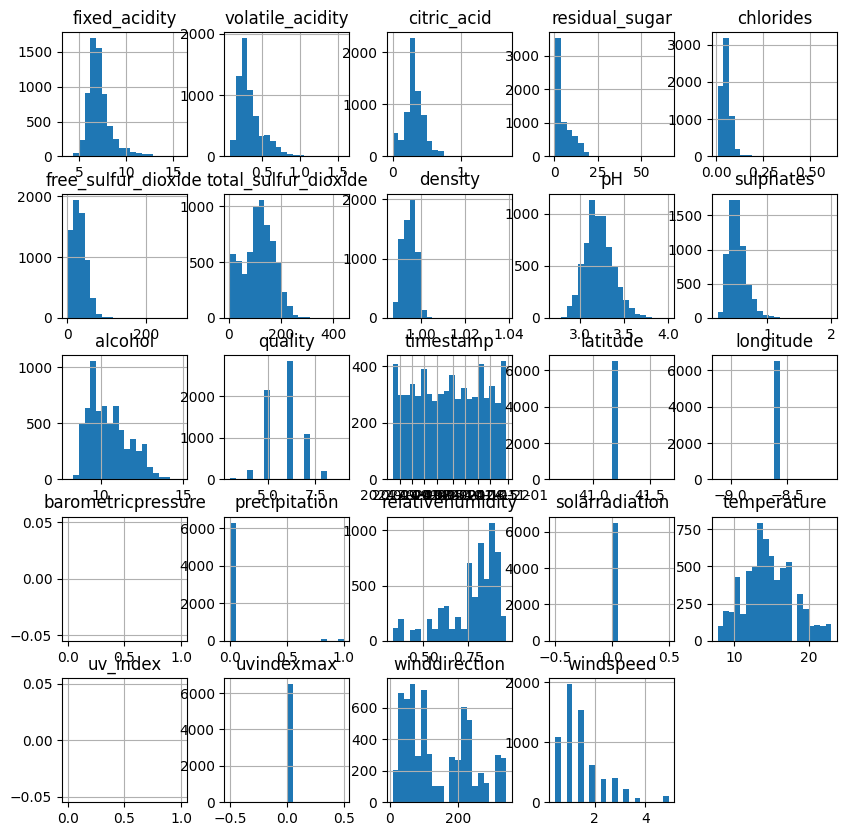

In [38]:
# Get the numerical variables from train_df
numerical_features = [feature for feature in df.columns if df[feature].dtype != object]
print(numerical_features)

df.hist(bins=20, figsize=(10, 10))
plt.show()

In [39]:
df.isnull().sum()

fixed_acidity              0
volatile_acidity           0
citric_acid                0
residual_sugar             0
chlorides                  0
free_sulfur_dioxide        0
total_sulfur_dioxide       0
density                    0
pH                         0
sulphates                  0
alcohol                    0
quality                    0
type                       0
timestamp                  0
date_observed              0
time_observed              0
entity_id                  0
entity_type                0
latitude                   0
longitude                  0
name                       0
barometricpressure      6497
precipitation              0
relativehumidity           0
solarradiation             0
temperature                0
uv_index                6497
uvindexmax                 0
winddirection              0
windspeed                112
dtype: int64

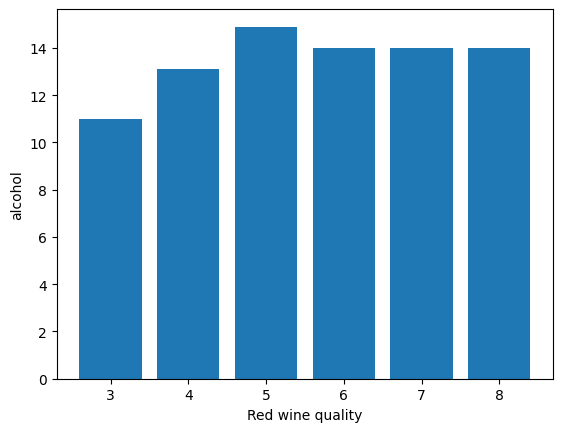

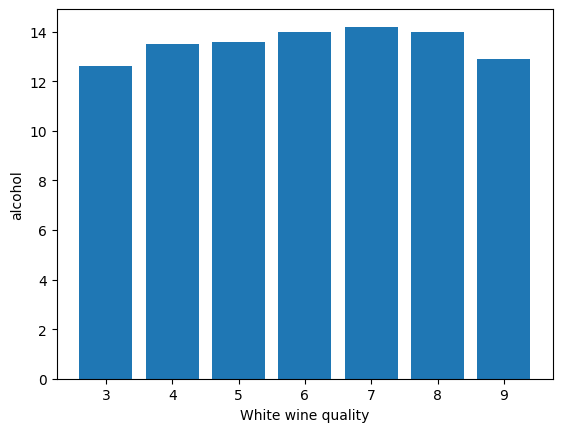

In [40]:
plt.bar(df1['quality'], df1['alcohol'])
plt.xlabel('Red wine quality')
plt.ylabel('alcohol')
plt.show()

plt.bar(df2['quality'], df2['alcohol'])
plt.xlabel('White wine quality')
plt.ylabel('alcohol')
plt.show()


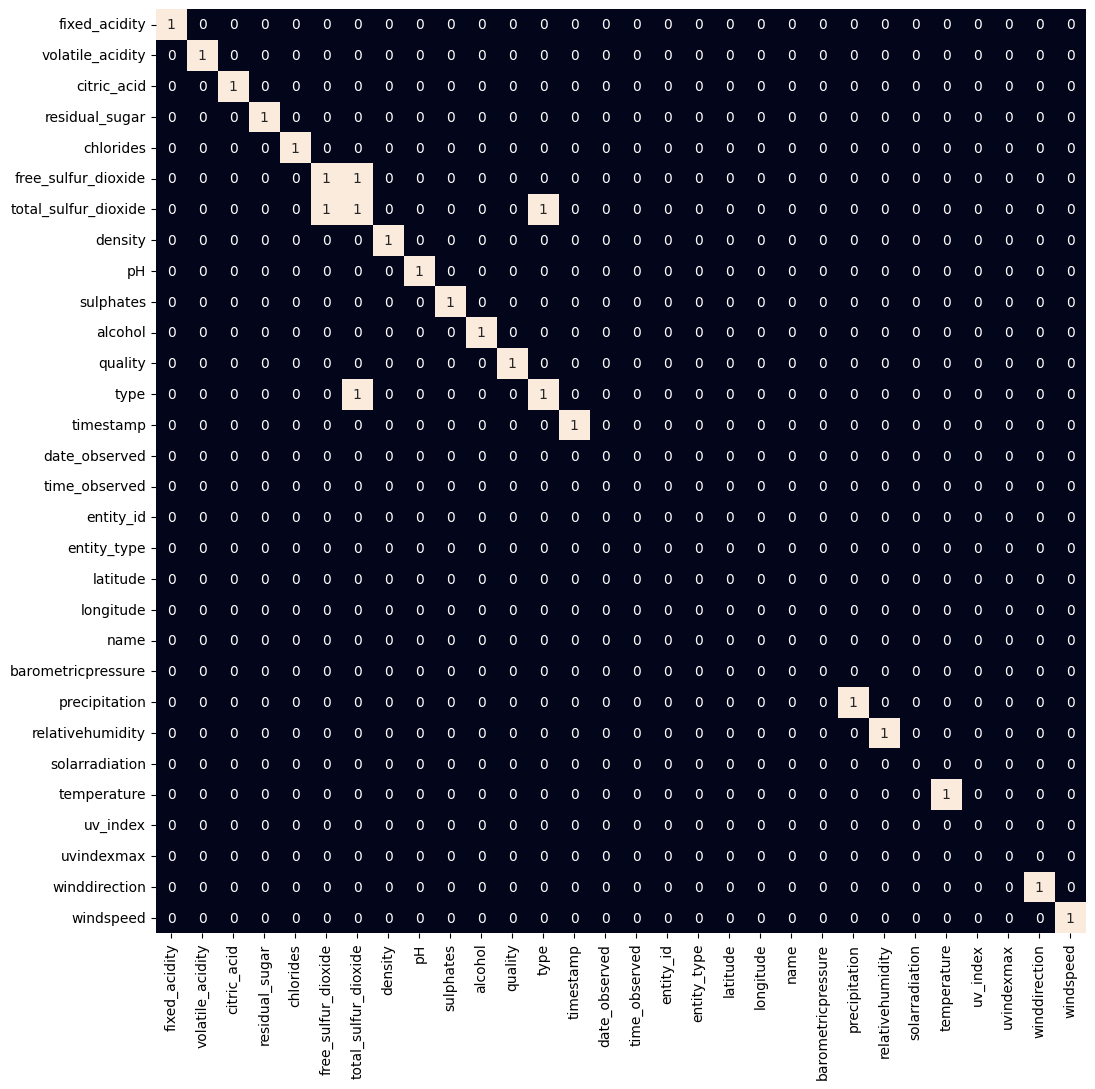

In [41]:
# Convert 'object' columns to numerical if they represent numbers
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, replace non-convertibles with NaN
        except:
            pass  # Skip columns that cannot be converted

plt.figure(figsize=(12, 12))
sb.heatmap(df.corr() > 0.7, annot=True, cbar=False)
plt.show()

In [42]:
# Drop unnecessary columns (adjust based on your analysis)
df.drop(columns=['entity_id', 'entity_type', 'name', 'latitude', 'longitude', 'date_observed', 'time_observed', 'barometricpressure', 'uv_index', 'uvindexmax', 'solarradiation'], inplace=True)

# Extract year, month, and day (optional: use month to analyze growing season)
df['month'] = df['timestamp'].dt.month

df.drop(columns=['timestamp'], inplace=True)

In [43]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type,precipitation,relativehumidity,temperature,winddirection,windspeed,month
0,7.3,0.25,0.36,13.1,0.050,35.0,200.0,0.99860,3.04,0.46,8.9,7,1,0.0,0.91,7.777778,101.0,0.44704,8
1,8.3,0.60,0.25,2.2,0.118,9.0,38.0,0.99616,3.15,0.53,9.8,5,0,0.0,0.91,7.777778,101.0,0.44704,8
2,8.3,0.16,0.48,1.7,0.057,31.0,98.0,0.99430,3.15,0.41,10.3,6,1,0.0,0.91,7.777778,101.0,0.44704,8
3,7.5,0.34,0.28,4.0,0.028,46.0,100.0,0.98958,3.20,0.50,13.2,7,1,0.0,0.91,7.777778,101.0,0.44704,8
4,7.0,0.31,0.29,1.4,0.037,33.0,128.0,0.98960,3.12,0.36,12.2,7,1,0.0,0.91,7.777778,101.0,0.44704,8


In [44]:
df = df.drop('total_sulfur_dioxide', axis=1)
df['best_quality'] = [1 if x > 5 else 0 for x in df.quality]

In [45]:
features = df.drop(['quality', 'best_quality'], axis=1)
target = df['best_quality']

xtrain, xtest, ytrain, ytest = train_test_split(features, target, test_size=0.2, random_state=40)

# Reset indices for alignment
xtest = pd.DataFrame(xtest, columns=features.columns).reset_index(drop=True)
ytest = ytest.reset_index(drop=True)

# Impute missing values after splitting
imputer = SimpleImputer(strategy='mean')
xtrain = imputer.fit_transform(xtrain)
xtest = imputer.transform(xtest)

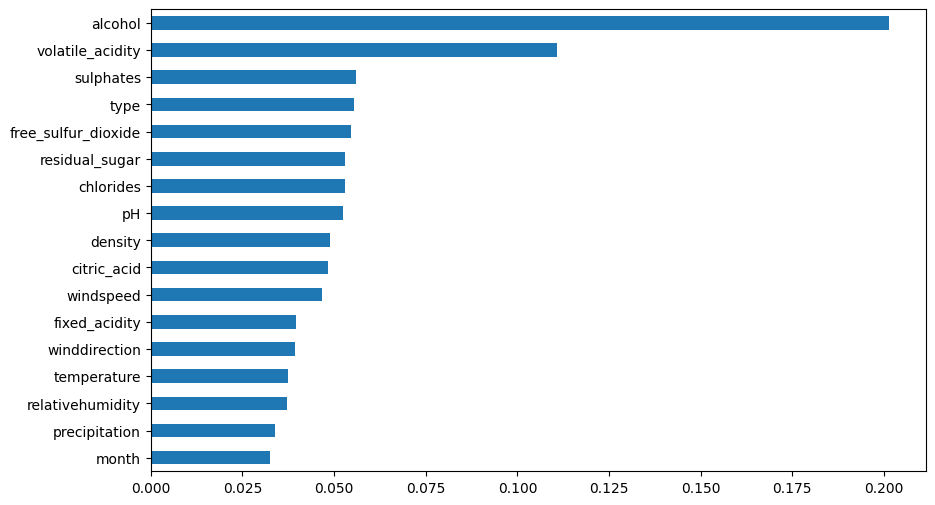

In [46]:
# # Train XGBoost to check feature importance
xgb_model = XGBClassifier().fit(xtrain, ytrain)
importances = pd.Series(xgb_model.feature_importances_, index=features.columns)
importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.show()


Evaluating LogisticRegression:
Validation Accuracy: 0.7369
              precision    recall  f1-score   support

           0       0.68      0.57      0.62       489
           1       0.76      0.84      0.80       811

    accuracy                           0.74      1300
   macro avg       0.72      0.70      0.71      1300
weighted avg       0.73      0.74      0.73      1300



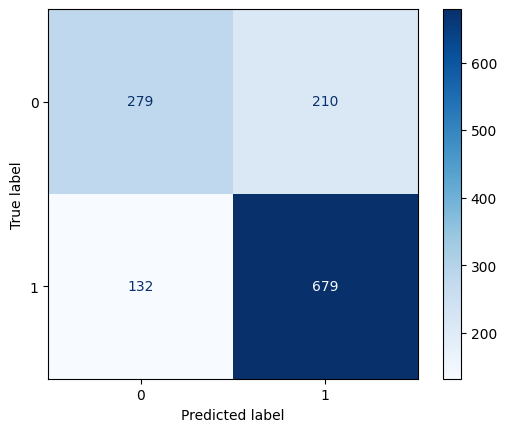


Evaluating XGBClassifier:
Validation Accuracy: 0.7985
              precision    recall  f1-score   support

           0       0.75      0.71      0.72       489
           1       0.83      0.85      0.84       811

    accuracy                           0.80      1300
   macro avg       0.79      0.78      0.78      1300
weighted avg       0.80      0.80      0.80      1300



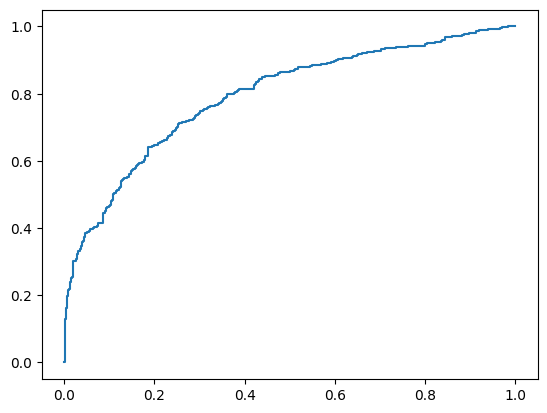

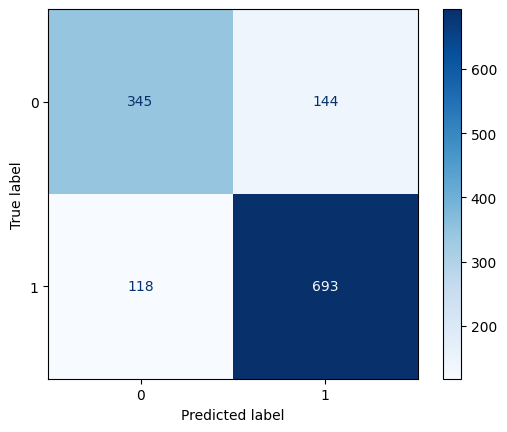


Evaluating SVC:
Validation Accuracy: 0.7292
              precision    recall  f1-score   support

           0       0.69      0.51      0.59       489
           1       0.75      0.86      0.80       811

    accuracy                           0.73      1300
   macro avg       0.72      0.69      0.69      1300
weighted avg       0.72      0.73      0.72      1300



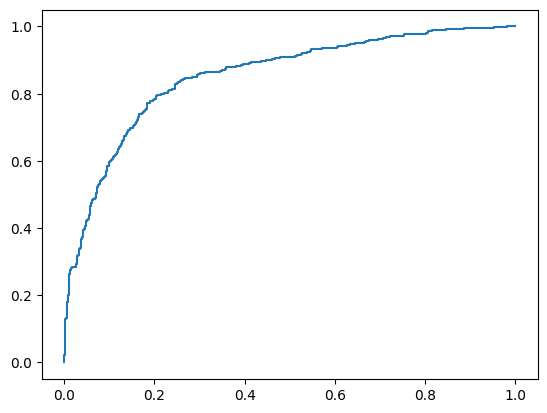

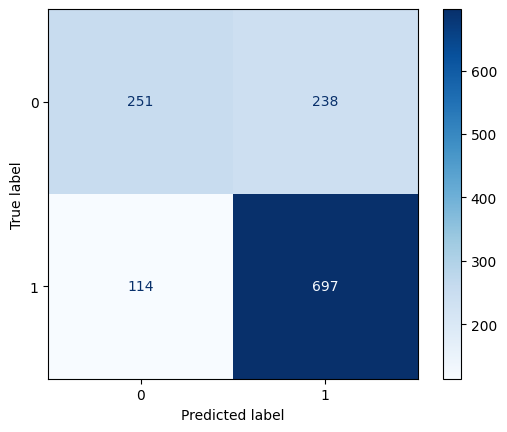


Evaluating RandomForestClassifier:
Validation Accuracy: 0.8038
              precision    recall  f1-score   support

           0       0.77      0.69      0.72       489
           1       0.82      0.87      0.85       811

    accuracy                           0.80      1300
   macro avg       0.79      0.78      0.79      1300
weighted avg       0.80      0.80      0.80      1300



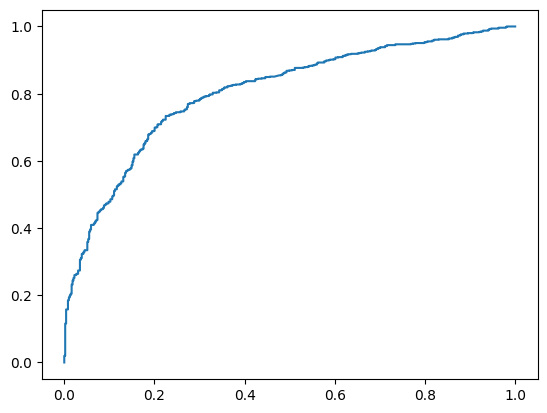

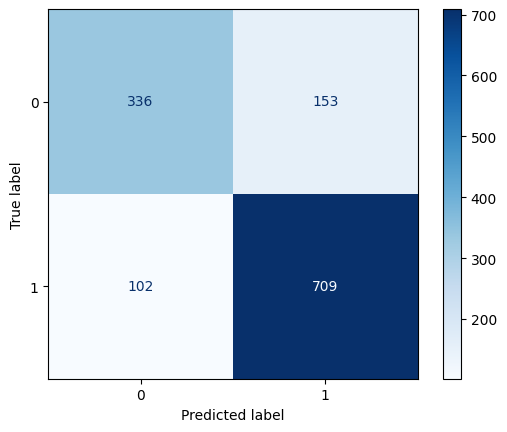


Evaluating GradientBoostingClassifier:
Validation Accuracy: 0.7523
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       489
           1       0.78      0.84      0.81       811

    accuracy                           0.75      1300
   macro avg       0.74      0.72      0.73      1300
weighted avg       0.75      0.75      0.75      1300



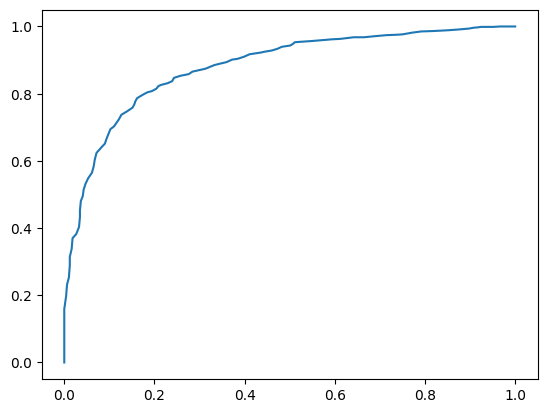

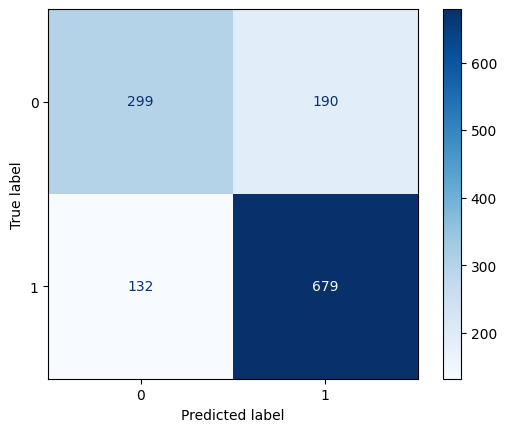

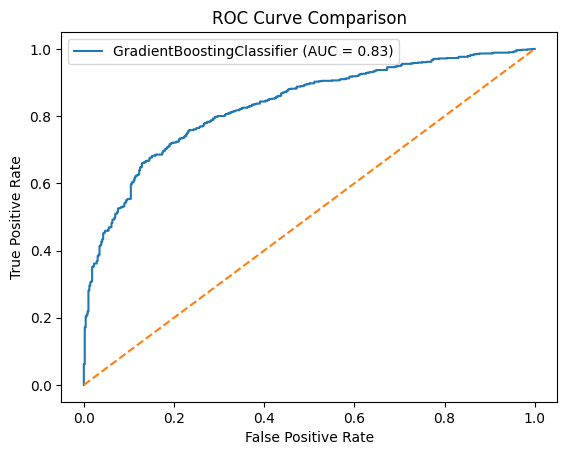

In [47]:
# Normalization
scaler = MinMaxScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

# Define models
models = [
    LogisticRegression(),
    XGBClassifier(),
    SVC(kernel='rbf', probability=True),  # Added probability=True for ROC curve
    RandomForestClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(n_estimators=100, random_state=42)
]

# Evaluation function
def evaluate_model(model, xtrain, ytrain, xtest, ytest):
    model.fit(xtrain, ytrain)
    ytest_pred = model.predict(xtest)
    ytest_proba = model.predict_proba(xtest)[:, 1] if hasattr(model, 'predict_proba') else None

    print(f'Validation Accuracy: {metrics.accuracy_score(ytest, ytest_pred):.4f}')
    print(classification_report(ytest, ytest_pred))

    cm = confusion_matrix(ytest, ytest_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.show()

    if ytest_proba is not None:
        fpr, tpr, _ = roc_curve(ytest, ytest_proba)
        plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc_score(ytest, ytest_proba):.2f})')

for model in models:
    print(f'\nEvaluating {model.__class__.__name__}:')
    evaluate_model(model, xtrain, ytrain, xtest, ytest)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


In [48]:
# Error Analysis for the best model (e.g., XGBClassifier)
best_model = models[1]  # Assuming XGBClassifier is best

# Identify false positives and false negatives
predictions = best_model.predict(xtest)
false_positives = (predictions == 1) & (ytest == 0)
false_negatives = (predictions == 0) & (ytest == 1)

print(f'False Positives: {np.sum(false_positives)}')
print(f'False Negatives: {np.sum(false_negatives)}')

False Positives: 144
False Negatives: 118


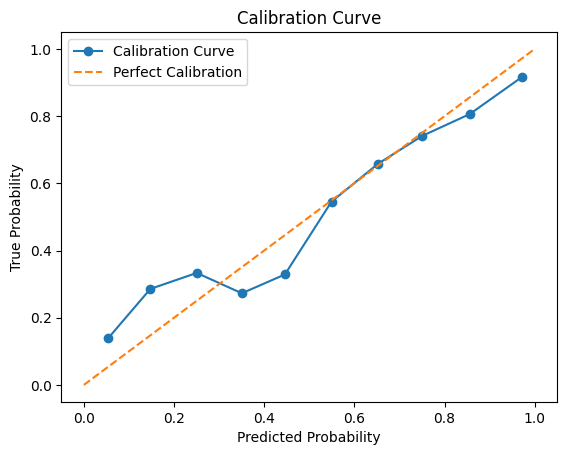

In [ ]:

# Calibration Plot (Optional for probabilistic models)
if hasattr(best_model, 'predict_proba'):
    prob_true, prob_pred = calibration_curve(ytest, best_model.predict_proba(xtest)[:, 1], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()

In [50]:
joblib.dump(best_model, 'wine_quality_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(imputer, 'imputer.pkl')

['imputer.pkl']